# Success rate by Main Category and USD Goal

Responsibility: Yahia Ehab - 7037125

In [18]:
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col


# Creating a spark context class
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

# Creating a spark session
spark = (
    SparkSession.builder.appName("Python Spark DataFrames basic example")
    .config("spark.some.config.option", "some-value")
    .getOrCreate()
)

In [19]:
df = pd.read_csv(".//kick_starter_cleaned.csv")
df['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [20]:
kick_starter_df = spark.read.csv('.//kick_starter_cleaned.csv', header=True, inferSchema=True)

kick_starter_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: string (nullable = true)
 |-- goal: string (nullable = true)
 |-- launched: string (nullable = true)
 |-- pledged: string (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: string (nullable = true)
 |-- country: string (nullable = true)
 |-- usd_pledged_real: string (nullable = true)
 |-- usd_goal_real: string (nullable = true)



## Data Preparation

### Imports

In [21]:
from pyspark.sql.functions import log, col
from pyspark.sql.types import FloatType
from pyspark.ml.feature import Bucketizer

### Listing Main Categories

In [22]:
specified_categories = [
    "Publishing",
    "Film & Video",
    "Music",
    "Food",
    "Design",
    "Crafts",
    "Games",
    "Comics",
    "Fashion",
    "Theater",
    "Art",
    "Photography",
    "Technology",
    "Dance",
    "Journalism",
]

### Remove rows with null values

In [23]:
kick_starter_df_cleaned = kick_starter_df.na.drop().filter(
    col("main_category").isin(specified_categories)
)

### Casting attributes to match operations requirements
`usd_goal_real` to FloatType

In [24]:
kick_starter_df_cleaned = kick_starter_df_cleaned.withColumn(
    "usd_goal_real", col("usd_goal_real").cast(FloatType())
)

### Logarithmic scaling 
Log Scaling to `usd_goal_real` to reduce skewness and spread out the values more evenly.

In [25]:

kick_starter_df_cleaned = kick_starter_df_cleaned.withColumn(
    "log_usd_goal_real", log(col("usd_goal_real") + 1)
)

### Normalization
Normalizing `log_usd_goal_real` using Min-Max scaling to convert the values to a range between 0 and 1.

In [26]:
min_log_usd_goal_real = kick_starter_df_cleaned.agg(
    {"log_usd_goal_real": "min"}
).collect()[0][0]
max_log_usd_goal_real = kick_starter_df_cleaned.agg(
    {"log_usd_goal_real": "max"}
).collect()[0][0]

kick_starter_df_cleaned = kick_starter_df_cleaned.withColumn(
    "normalized_log_usd_goal_real",
    (col("log_usd_goal_real") - min_log_usd_goal_real)
    / (max_log_usd_goal_real - min_log_usd_goal_real),
)

### Bucketing

- Define bucket splits for normalized_log_usd_goal_real
- Apply the bucketizer
- Convert the bucket index to a human-readable format


In [27]:
splits = [-float("inf"), 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, float("inf")]

bucketizer = Bucketizer(
    splits=splits, inputCol="normalized_log_usd_goal_real", outputCol="goal_bucket"
)

kick_starter_df_cleaned = bucketizer.transform(kick_starter_df_cleaned)

bucket_labels = [
    "[0-0.1)",
    "[0.1-0.2)",
    "[0.2-0.3)",
    "[0.3-0.4)",
    "[0.4-0.5)",
    "[0.5-0.6)",
    "[0.6-0.7)",
    "[0.7-0.8)",
    "[0.8-0.9)",
    "[0.9-1.0]",
]

### Finalizing

Converting the bucket number to a string label and add it as a new column

In [28]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

bucket_label_udf = udf(lambda x: bucket_labels[int(x)], StringType()) 
kick_starter_df_cleaned = kick_starter_df_cleaned.withColumn(
    "goal_bucket_label", bucket_label_udf(col("goal_bucket"))
)

kick_starter_df_cleaned.createOrReplaceTempView("kickstarter_cleaned")

## Query: Success Rate by main_category and goal_bucket_label

In [29]:
# Execute the query
success_rate_by_goal_df = spark.sql(
    """
    SELECT 
        main_category, 
        goal_bucket_label,
        COUNT(*) AS total_projects, 
        SUM(CASE WHEN state = 'successful' THEN 1 ELSE 0 END) AS successful_projects, 
        (SUM(CASE WHEN state = 'successful' THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS success_rate
    FROM 
        kickstarter_cleaned
    GROUP BY 
        main_category, goal_bucket_label
    ORDER BY 
        main_category, goal_bucket_label
"""
)
success_rate_by_goal_df.show()

+-------------+-----------------+--------------+-------------------+------------------+
|main_category|goal_bucket_label|total_projects|successful_projects|      success_rate|
+-------------+-----------------+--------------+-------------------+------------------+
|          Art|          [0-0.1)|            91|                 69| 75.82417582417582|
|          Art|        [0.1-0.2)|           295|                157| 53.22033898305085|
|          Art|        [0.2-0.3)|          1814|                979|  53.9691289966924|
|          Art|        [0.3-0.4)|          8671|               4270|49.244608464998265|
|          Art|        [0.4-0.5)|         13078|               5205|39.799663557118826|
|          Art|        [0.5-0.6)|          3550|                769|21.661971830985916|
|          Art|        [0.6-0.7)|           479|                 18|3.7578288100208765|
|          Art|        [0.7-0.8)|            77|                  1|1.2987012987012987|
|          Art|        [0.8-0.9)

## Data Visualization

### Preparation :

- Convert the result to a pandas DataFrame for visualization
- Create a pivot table for better visualization


In [30]:
success_rate_by_goal_pd = success_rate_by_goal_df.toPandas()

pivot_df = success_rate_by_goal_pd.pivot(
    index="goal_bucket_label", columns="main_category", values="success_rate"
)

### Output

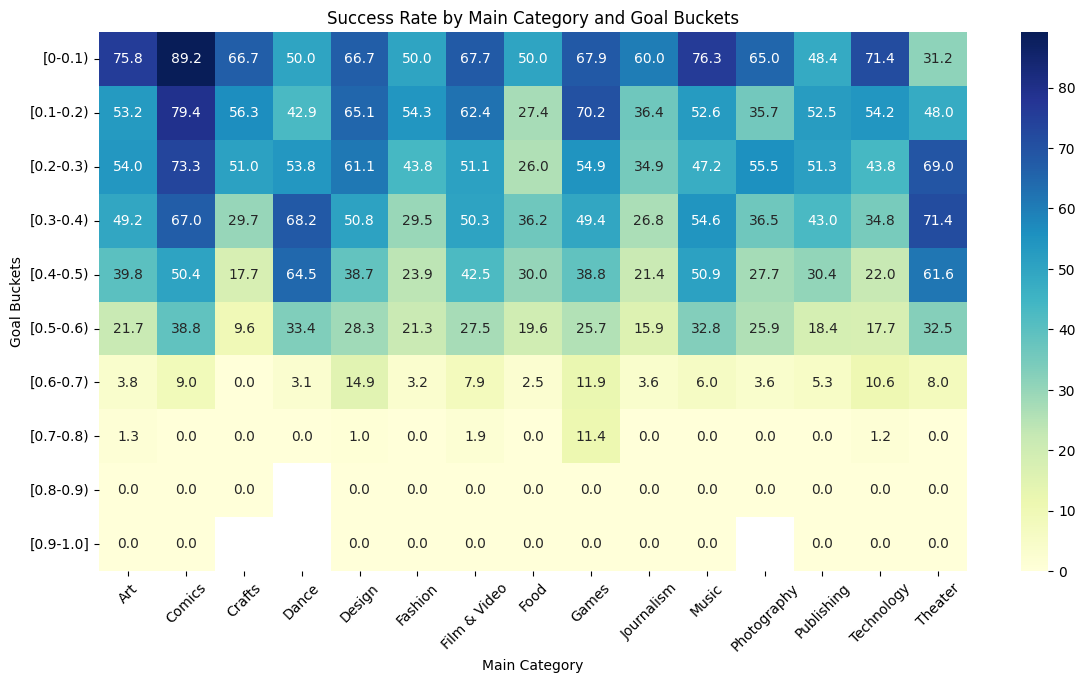

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_df = success_rate_by_goal_pd.pivot(
    index="goal_bucket_label", columns="main_category", values="success_rate"
)

plt.figure(figsize=(14, 7))
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Success Rate by Main Category and Goal Buckets")
plt.xlabel("Main Category")
plt.ylabel("Goal Buckets")
plt.xticks(rotation=45)
plt.show()

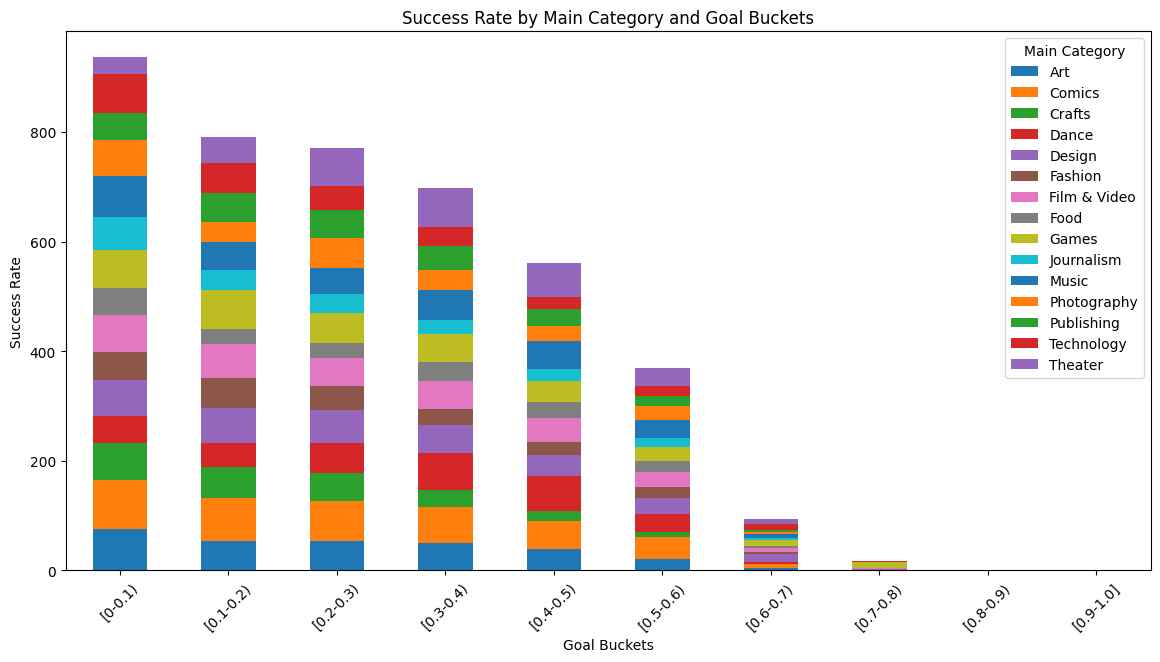

In [32]:
pivot_df.plot(kind="bar", stacked=True, figsize=(14, 7))
plt.title("Success Rate by Main Category and Goal Buckets")
plt.xlabel("Goal Buckets")
plt.ylabel("Success Rate")
plt.xticks(rotation=45)
plt.legend(title="Main Category")
plt.show()